## Loading Libs

In [1]:
import transformers

from transformers import BertForTokenClassification, BertTokenizer
import torch
import numpy as np

## Loading dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("lener_br")

Reusing dataset lener_br (/home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382)


In [3]:
dataset['test'][0]

{'id': '0',
 'ner_tags': [0,
  0,
  0,
  11,
  12,
  0,
  1,
  0,
  3,
  4,
  11,
  12,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  5,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  4,
  0],
 'tokens': ['Número',
  'do',
  'Acórdão',
  'ACÓRDÃO',
  '1160/2016',
  '-',
  'PLENÁRIO',
  'Relator',
  'AUGUSTO',
  'NARDES',
  'Processo',
  '006.010/2000-4',
  'Tipo',
  'de',
  'processo',
  'TOMADA',
  'DE',
  'CONTAS',
  'SIMPLIFICADA',
  '(',
  'TCSP',
  ')',
  'Data',
  'da',
  'sessão',
  '11/05/2016',
  'Número',
  'da',
  'ata',
  '16/2016',
  'Relator',
  'da',
  'deliberação',
  'recorrida',
  'Ministra',
  'Ana',
  'Arraes',
  '.']}

In [4]:
NER_tags = ["O", "B-ORGANIZACAO", "I-ORGANIZACAO", "B-PESSOA", "I-PESSOA", "B-TEMPO", "I-TEMPO", "B-LOCAL", "I-LOCAL", "B-LEGISLACAO", "I-LEGISLACAO", "B-JURISPRUDENCIA", "I-JURISPRUDENCIA"]
num_labels = len(NER_tags)

## Loading model checkpoint for tokenizer and for model weight initialization

In [5]:
PRE_TRAINED_MODEL = 'neuralmind/bert-base-portuguese-cased'

In [6]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

In [7]:
model = BertForTokenClassification.from_pretrained(
    PRE_TRAINED_MODEL,
    num_labels=num_labels,
)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

In [8]:
model.num_labels

13

# Data exploration

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

from matplotlib import rc

In [14]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

## Analysing number of labels

In [40]:
tags = np.concatenate(dataset['train'][:]['ner_tags'])

/home/caiotulio/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


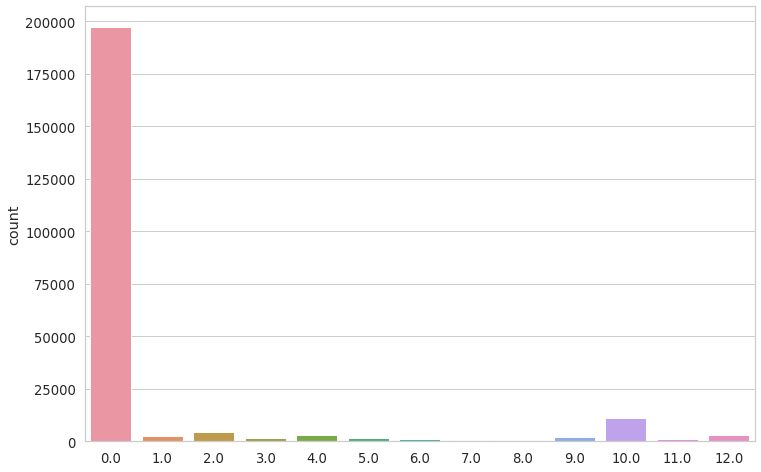

In [51]:
sns.countplot(tags)

In [45]:
identified_tags = list(filter(lambda t: t > 0, tags))

/home/caiotulio/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


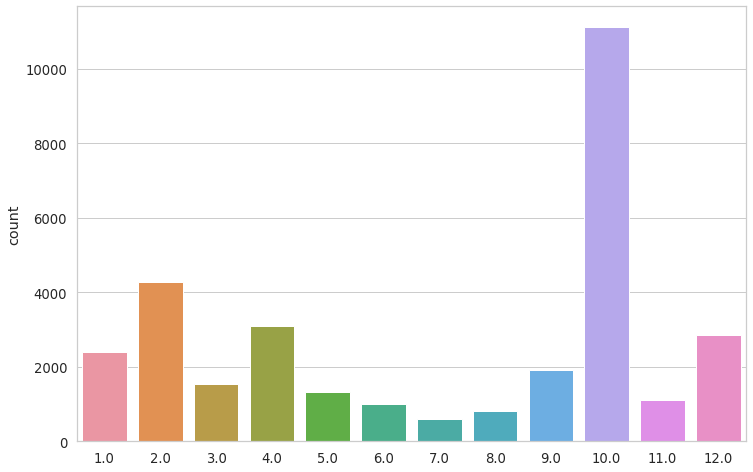

In [52]:
sns.countplot(identified_tags)

## Analysing sentence size

In [97]:
def get_length(tokens):
    return [len(s) for s in tokens]

In [98]:
tokens = dataset['train'][:]['tokens']
lengths = get_length(tokens)

In [83]:
teste = list(filter(lambda l: l > 200,lengths))

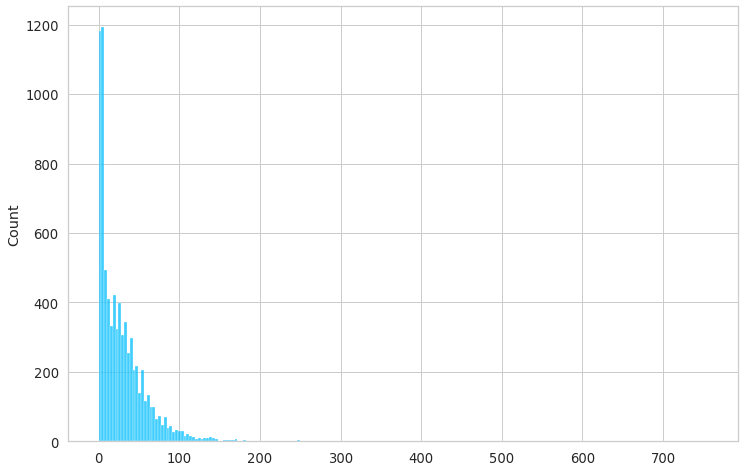

In [144]:
sns.histplot(lengths)

In [131]:
longer_sentences = list(filter(lambda t: len(t) > 512, tokens)) # Bert maximum sentence size

In [ ]:
" ".join(longer_sentences[0])

In [146]:
TOKEN_SIZE_THRESHOLD = 256

In [147]:
def categorize(token):
    return 0 if len(token) < TOKEN_SIZE_THRESHOLD else 1

In [148]:
tokens_by_size = list(map(categorize, tokens))
larger_than_threshold = np.count_nonzero(tokens_by_size)
smaller_than_threshold = len(tokens_by_size) - larger_than_200

print(f"Tokens menores que {TOKEN_SIZE_THRESHOLD}: {smaller_than_200}; Maiores que {TOKEN_SIZE_THRESHOLD}: {larger_than_200}")

Tokens menores que 256: 7795; Maiores que 256: 33


In [122]:
print(f"A maior sentença tem comprimento {np.max(lengths)}") 

A maior sentença tem comprimento 755


A esmagadora maioria das sentenças tem tamanho menor do que 256, acho que dá só pra descartar essas maiores. (analise meio porca, mas enfim)

## Testing out the tokenizer

In [74]:
sample = dataset['test'][10] # numero aleatório
sentence = sample['tokens']
tags = sample['ner_tags']
print(sentence)
print(tags)

['Ielton', 'Carvalho', 'Piancó', '(', '13469-E/OAB-DF', ')', 'e', 'outros', ',', 'representando', 'Grupo', 'Ok', 'Construções', 'e', 'Empreendimentos', 'Ltda.', '8.2', '.']
[3, 4, 4, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 0, 0]


In [75]:
tokenizer.tokenize(" ".join(sentence))

['I',
 '##el',
 '##ton',
 'Carvalho',
 'Pia',
 '##nc',
 '##ó',
 '(',
 '13',
 '##46',
 '##9',
 '-',
 'E',
 '/',
 'O',
 '##AB',
 '-',
 'D',
 '##F',
 ')',
 'e',
 'outros',
 ',',
 'representando',
 'Grupo',
 'Ok',
 'Constru',
 '##ções',
 'e',
 'Emp',
 '##ree',
 '##ndimentos',
 'Ltda',
 '.',
 '8',
 '.',
 '2',
 '.']

(O output do tokenizer do bertimbau é diferente da tokenização fornecida pelo dataset. O dataset aparentemente fez um tokenização baseado em espaços. Um problema de tokenizar do zero seria lidar com pontuação estranha de texto jurídico)